# import libreries for the experiment

In [1]:
import sys
import os
import json
import random 

import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       

import cv2                                                                         
import mediapipe as mp  

from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split                                                
from collections import defaultdict
from typing import Callable, List, Tuple
from numpy.typing import NDArray

import torch
from torch import nn
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
    
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import captum

from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance

In [2]:
sys.path.append(os.path.abspath('../src'))
import prepare_datasets
import preprocess_utils 
import models  
import train_utils 
import plot_utils
import train
import analyse_layer

# Getting landmarks from WLASL 100 dataset

In [3]:
# define directories
#root= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/cleaned_WLASLdataset_35/WLASL100'
#save_dir= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/data/landmarks_cleaned_wlasl35/'
# 25fps (default)
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_WLASL100(root, prepare_datasets.wlasl35class_names, frame_numbers= 25)

In [4]:
#detections= prepare_datasets.fill_empty_detections(result[0])

In [5]:
#np.save(os.path.join(save_dir, 'detections.npy'), np.array(detections))     
#with open(os.path.join(save_dir, 'labels.json'), 'w') as file:
    #json.dump(result[1], file) 

# loading saved landmarks from WLASL 100 dataset

In [18]:
root_dir= os.path.dirname(os.getcwd())   # defining path to project folder
data_dir= os.path.join(root_dir, 'data') # path to dataset directories

wlasl= os.path.join(data_dir, 'landmarks_cleaned_wlasl35') # path to WLASL 100 directory

# loading detections and labels for WLASL dataset
wlasl35_detections= np.load(os.path.join(wlasl, 'detections.npy'), allow_pickle=True)
with open(os.path.join(wlasl, 'labels.json'), 'r') as file:
     wlasl35_labels= json.load(file)

In [19]:
print(wlasl35_detections.shape, len(wlasl35_labels))
print(type(wlasl35_detections), type(wlasl35_labels))

(505, 25, 1662) 505
<class 'numpy.ndarray'> <class 'list'>


# showing the video detections

In [8]:
video= wlasl35_detections[1]
second_video= wlasl35_detections[2]
ivd= preprocess_utils.interpolate_video_detections(video_detection_1= video,
                                                   video_detection_2= second_video, 
                                                   frame_structure= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)],
                                                   alpha= 0.5)
plot_utils.show_video_detections(video)
plot_utils.show_video_detections(second_video)
plot_utils.show_video_detections(ivd)

In [20]:
data= defaultdict(list)
for idx, label in enumerate(wlasl35_labels):
    data[label].append(wlasl35_detections[idx])

In [21]:
samples_per_word= []
for item in data.items():
    samples_per_word.append(len(item[1]))

print(samples_per_word)
print(len(samples_per_word))

[13, 18, 16, 16, 18, 17, 13, 17, 17, 14, 15, 16, 13, 16, 13, 14, 15, 14, 13, 13, 15, 15, 13, 13, 13, 13, 13, 13, 13, 14, 15, 13, 13, 14, 14]
35


# plotting average movements in the dataset

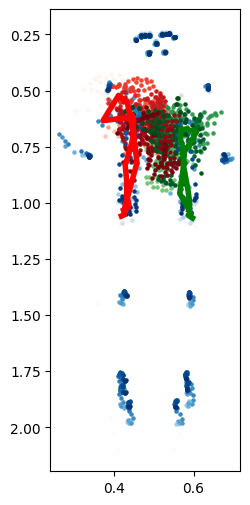

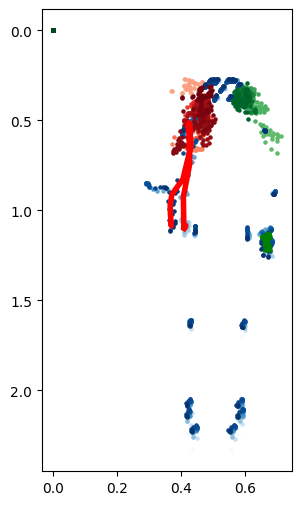

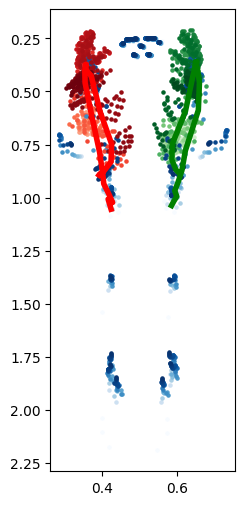

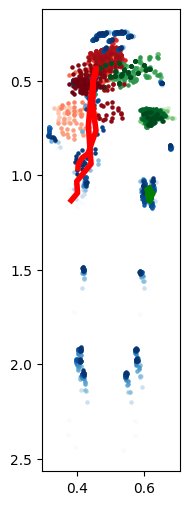

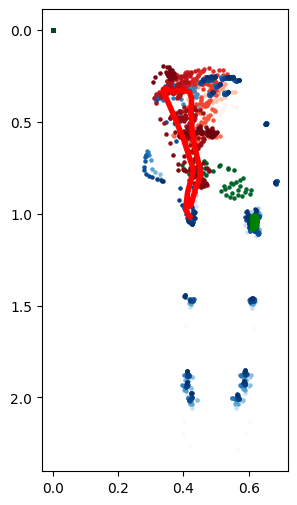

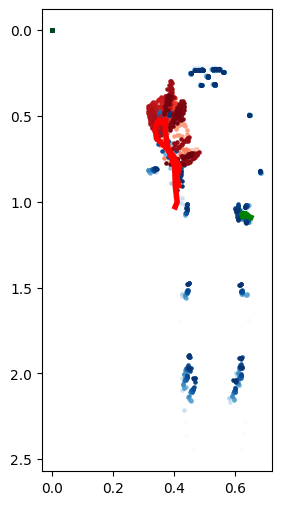

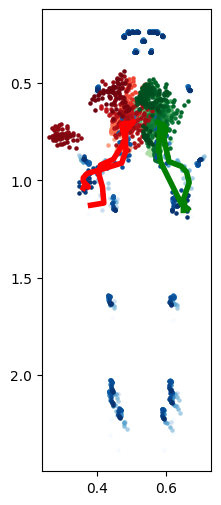

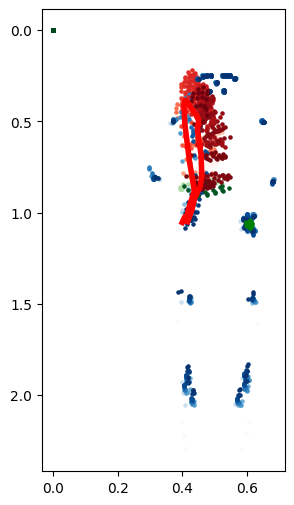

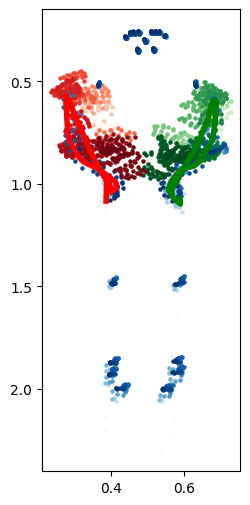

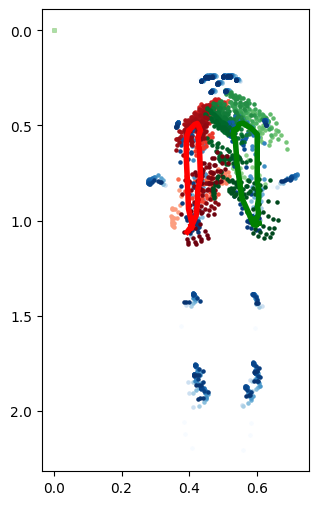

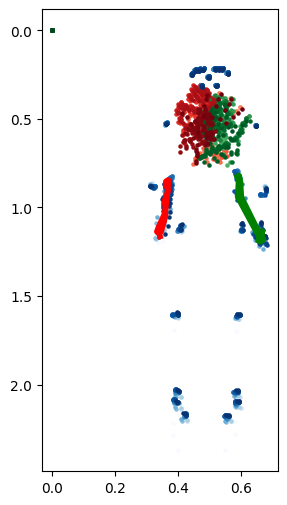

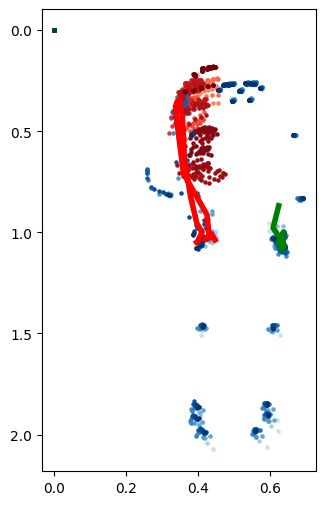

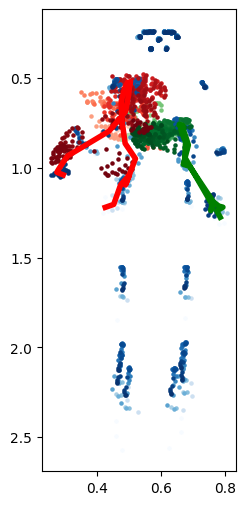

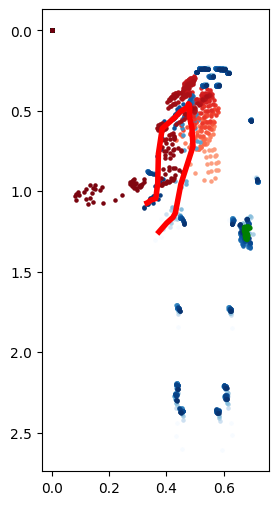

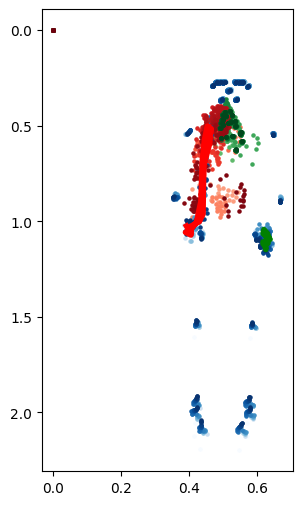

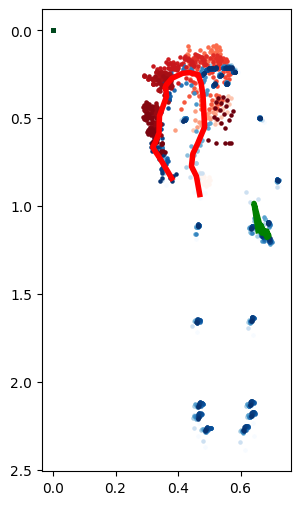

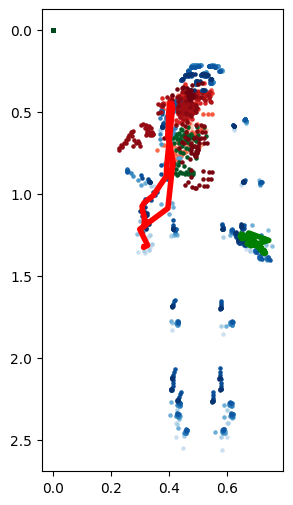

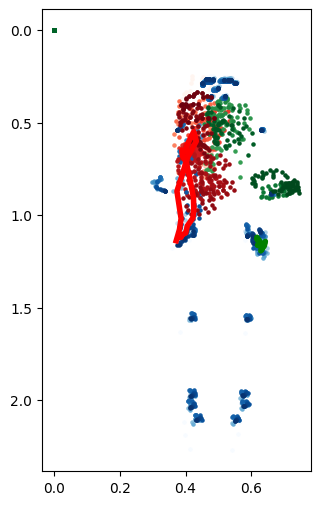

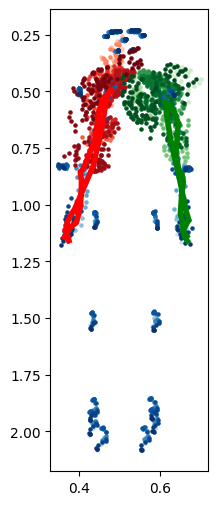

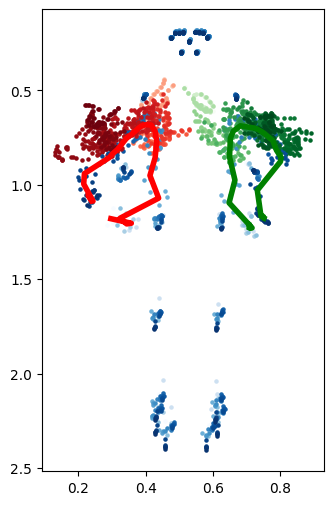

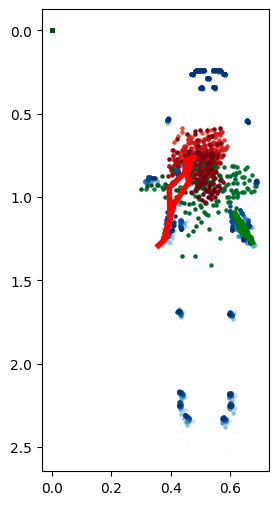

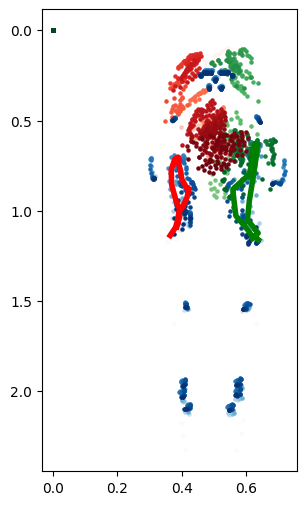

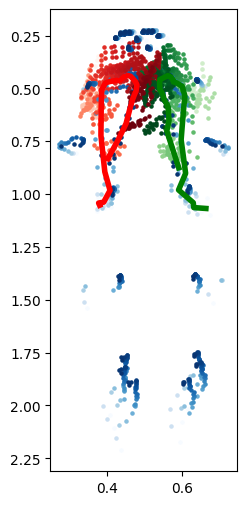

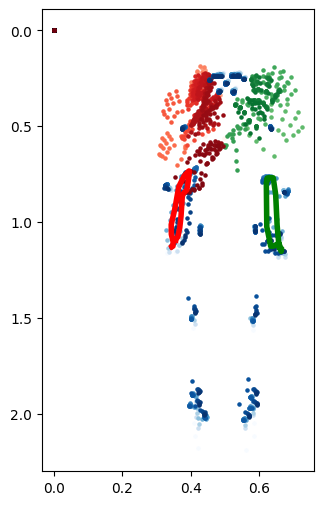

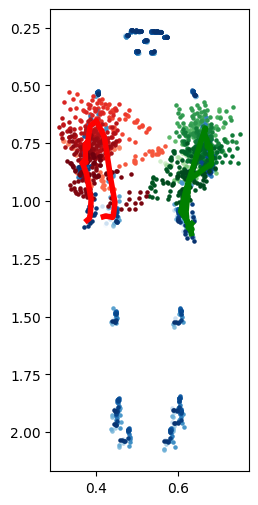

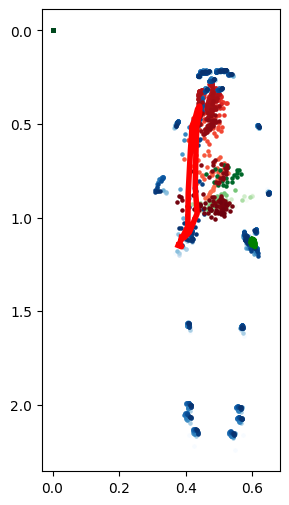

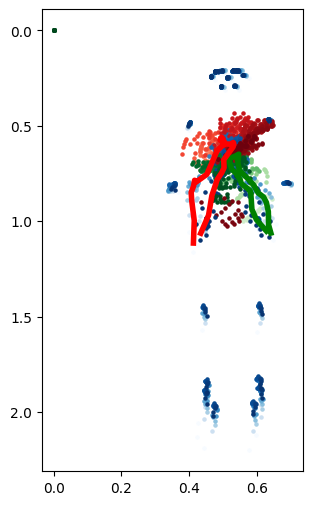

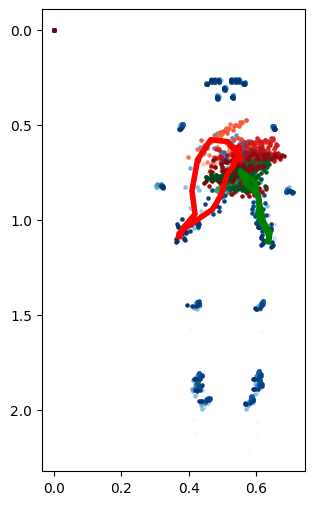

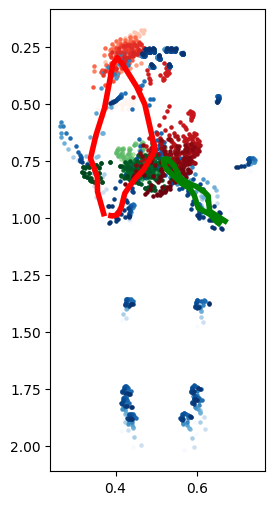

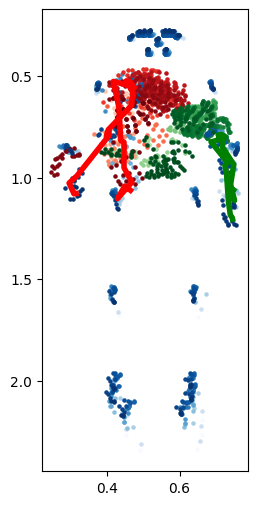

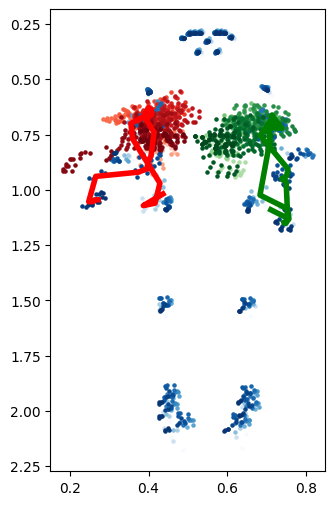

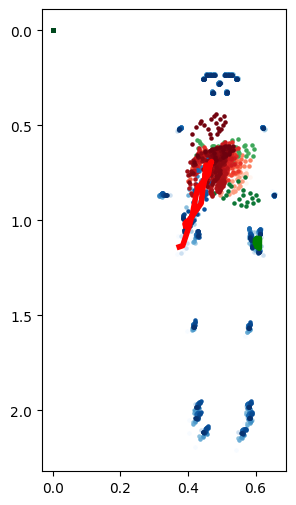

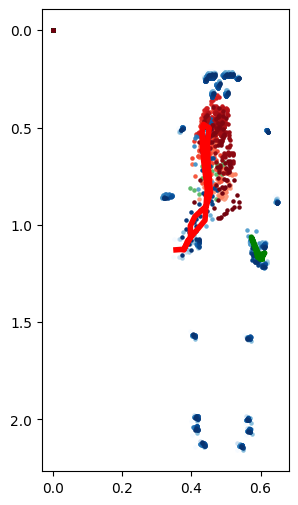

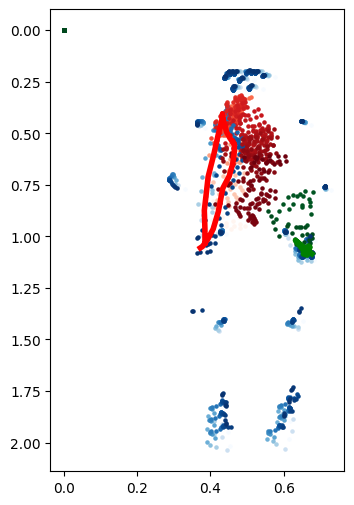

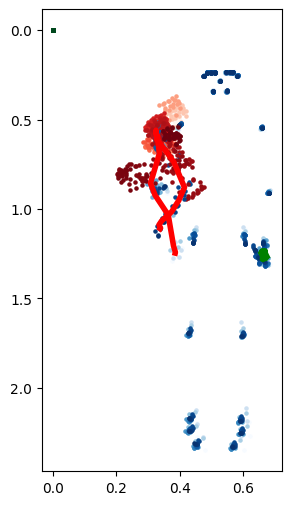

In [11]:
for idx, item in enumerate(data.items()):             # returns a list of tuples -> (label, video)
    mean_video= item[1][0]                            # initialize mean to be the fist video
    for video_detection in item[1]:
        mean_video= preprocess_utils.interpolate_video_detections(video_detection_1= mean_video,
                                                                  video_detection_2= video_detection,
                                                                  frame_structure= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)],
                                                                  alpha= 0.5) # calculate mean using linear interpolation
    # plotting the average movement for each label 
    plot_utils.plot_video_detection_as_MHI(video_detection= mean_video, 
                                           num_movements= 30,
                                           height= 720,
                                           width= 1280,
                                           save_path= f'{idx+1}.png')

# Connecting Cuda

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #set up device to cuda
print(device)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

cuda
NVIDIA GeForce RTX 3060 Laptop GPU
(8, 6)


# Eliminating face landmark: for faster training

In [9]:
#pose = np.arange(0, 132)
#lh_and_rh = np.arange(1536, 1662)
#indices_to_keep = np.concatenate((pose, lh_and_rh))   # Concatenate indices to keep
#filtered_detections = wlasl100_detections[:, :, indices_to_keep] # Filter the data to remove face landmarks
#filtered_detections.shape

In [35]:
print(type(wlasl35_labels))
print(wlasl35_labels[:3])

<class 'list'>
['all', 'all', 'all']


In [47]:
#splitting the dataset
x_train, x_test, y_train, y_test= train_test_split(wlasl35_detections, wlasl35_labels, test_size= 0.22,random_state=42, stratify=wlasl35_labels)
print(x_train.shape, len(y_train), x_test.shape, len(y_test))
# creating synthetic datapoints
#x_test, y_test = resample(wlasl35_detections, wlasl35_labels, n_samples=400, random_state=42)
#print(x_train.shape, len(y_train), x_test.shape, len(y_test))

x_train, y_train = preprocess_utils.interpolate_dataset(x_train, y_train, alpha= 0.5, num_interpolation_samples= 78)
x_test, y_test = preprocess_utils.interpolate_dataset(x_test, y_test, alpha= 0.5, num_interpolation_samples= 6)
print(x_train.shape, len(y_train), x_test.shape, len(y_test))

# defining indexes to keep
pose = np.arange(0, 132)
lh_and_rh = np.arange(1536, 1662)
indices_to_keep = np.concatenate((pose, lh_and_rh))   # Concatenate indices to keep

x_train = x_train[:, :, indices_to_keep] # Filter the data and remove face landmarks
x_test= x_test[:, :, indices_to_keep]    # filter the data and remove face landmarks

print(x_train.shape, len(y_train), x_test.shape, len(y_test))

(393, 25, 1662) 393 (112, 25, 1662) 112
(2406, 25, 1662) 2406 (238, 25, 1662) 238
(2406, 25, 258) 2406 (238, 25, 258) 238


In [48]:
traind= defaultdict(list)
for idx, label in enumerate(y_train):
    traind[label].append(x_train[idx])

testd= defaultdict(list)
for idx, label in enumerate(y_test):
    testd[label].append(x_test[idx])

In [49]:
samples_per_word_train, samples_per_word_test= [], []
for item in traind.items():
    samples_per_word_train.append(len(item[1]))

for item in testd.items():
    samples_per_word_test.append(len(item[1])) 

print(samples_per_word_train)
print(samples_per_word_test)

[55, 55, 66, 92, 78, 78, 91, 55, 91, 55, 91, 55, 55, 55, 55, 55, 92, 66, 91, 91, 66, 55, 66, 78, 55, 55, 66, 55, 78, 55, 78, 55, 66, 78, 78]
[6, 10, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 6, 6, 6, 6, 6, 10, 6, 6, 6, 6, 6, 6, 10, 6, 10, 6, 6, 10, 6, 10]


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


Training Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

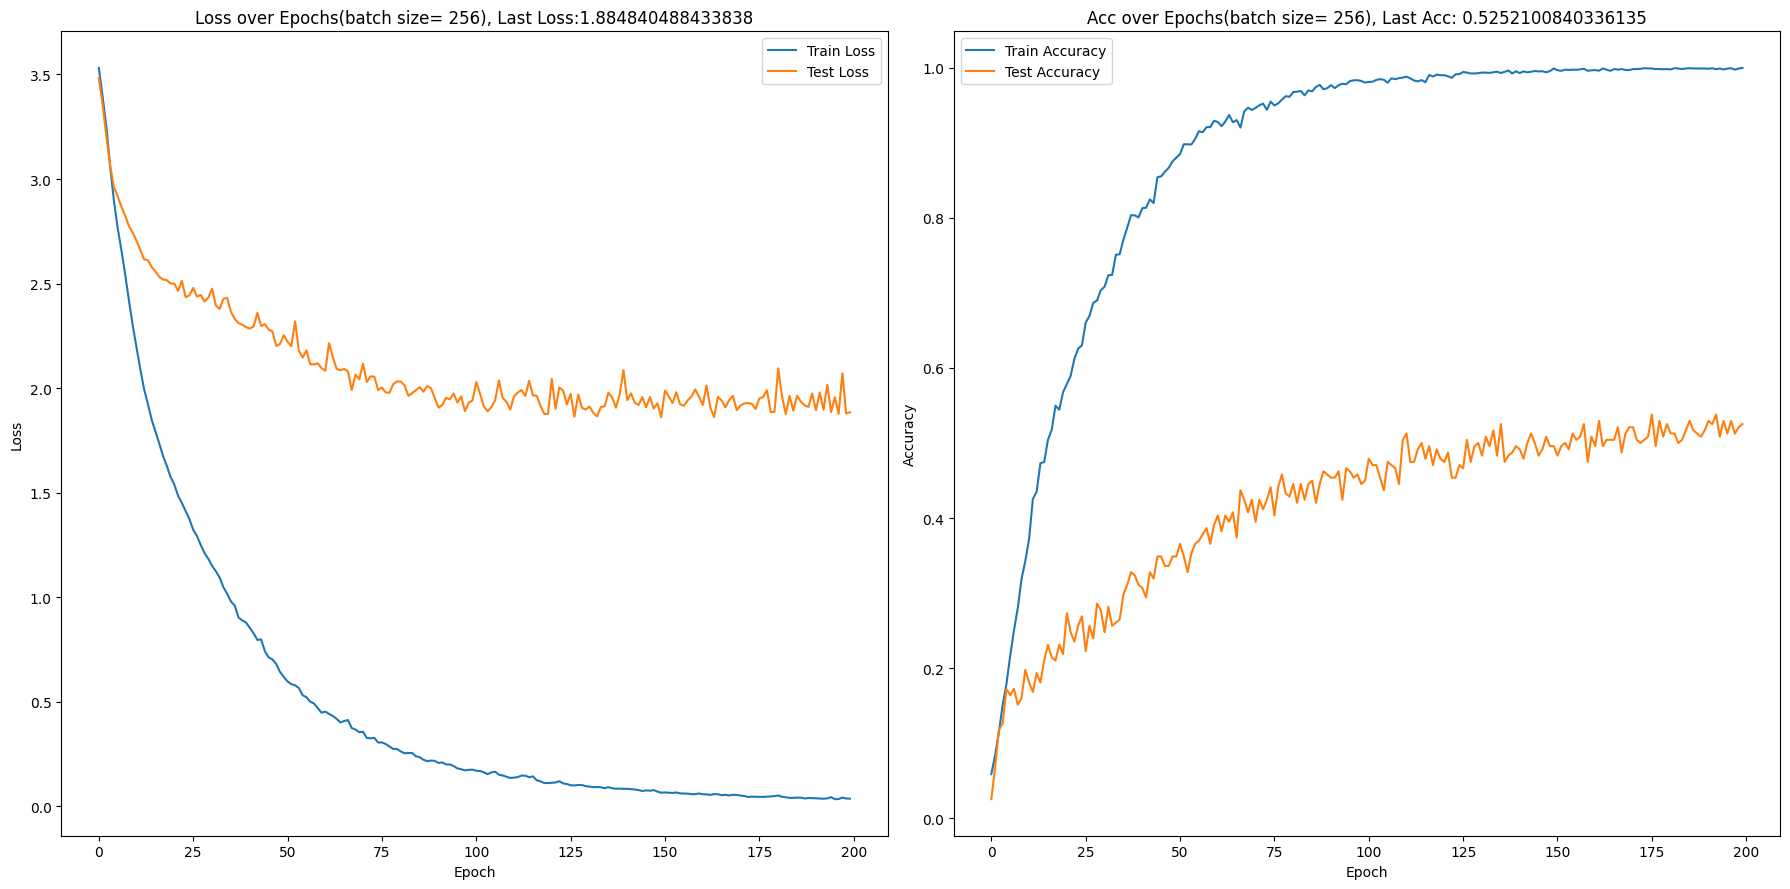

KeyboardInterrupt: 

In [50]:
x_train, y_train= preprocess_utils.convert(x_train, y_train, prepare_datasets.wlasl35class_names)
x_test, y_test= preprocess_utils.convert(x_test, y_test, prepare_datasets.wlasl35class_names)

print(type(x_train), type(y_train), type(x_test), type(y_test))

batch_size= 256
num_epochs= 200

train_dataset= train.CustomDataset(x_train, y_train)      # train_dataset
test_dataset= train.CustomDataset(x_test, y_test)         # test dataset

train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) # train dataloader 
test_loader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False)  # test dataloader

# making the model
model= models.Transformer(class_names= prepare_datasets.wlasl35class_names,
                          seq_len= 25, 
                          d_model= 258,
                          nhead= 6,
                          d_ff= 512, 
                          num_layers= 1)

model= model.to(device)                                # sending model to device: CUDA or CPU     
loss_fn = nn.CrossEntropyLoss()                        # cross entropy for loss
optimizer = optim.Adam(model.parameters(), lr= 0.0001) # Adam optimizer

experiment_dir= "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/experiment_results"
dataset_name= "WLASL35"
results_name= "yata"

log_dir =f'{experiment_dir}/{dataset_name}/{model.model_type}/runs/{results_name}/'         # directory for saving the tensorboard files

train_l, test_l, train_a, test_a, y_trues, y_preds = train_utils.train_model(num_epochs,
                                                                             model,
                                                                             train_loader,
                                                                             test_loader,
                                                                             optimizer,
                                                                             loss_fn,
                                                                             device)  # train model

plot_utils.plot_loss_accuracy(train_l, test_l, train_a, test_a, batch_size, 'loss_acc.png')  # loss acc
plot_utils.plot_confusion_matrix(y_trues, y_preds, prepare_datasets.wlasl35class_names, num_epochs, 'confmat.png')  # confusion matrix
plot_utils.draw_in_tensorboard(train_l, test_l, train_a, test_a, log_dir)  # drawing in tensor board

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Ensure wlasl35_labels is a NumPy array for K-Fold indexing
wlasl35_labels = np.array(wlasl35_labels)

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(wlasl35_detections)):
    print(f"Processing Fold {fold + 1}")

    # Splitting the dataset into training and testing for this fold
    x_train, x_test = wlasl35_detections[train_index], wlasl35_detections[test_index]
    y_train, y_test = wlasl35_labels[train_index], wlasl35_labels[test_index]

    print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # ** Interpolation (before convert) **
    x_train, y_train = preprocess_utils.interpolate_dataset(x_train, y_train, alpha=0.5, num_interpolation_samples=78)
    x_test, y_test = preprocess_utils.interpolate_dataset(x_test, y_test, alpha=0.5, num_interpolation_samples=6)
    print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # Defining indices to keep
    pose = np.arange(0, 132)
    lh_and_rh = np.arange(1536, 1662)
    indices_to_keep = np.concatenate((pose, lh_and_rh))

    x_train = x_train[:, :, indices_to_keep]  # Filter out unnecessary landmarks
    x_test = x_test[:, :, indices_to_keep]    # Filter out unnecessary landmarks

    print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # ** Convert (after interpolate) **
    x_train, y_train = preprocess_utils.convert(x_train, y_train, prepare_datasets.wlasl35class_names)
    x_test, y_test = preprocess_utils.convert(x_test, y_test, prepare_datasets.wlasl35class_names)

    print(type(x_train), type(y_train), type(x_test), type(y_test))

    # Create datasets and dataloaders for training and testing
    train_dataset = train.CustomDataset(x_train, y_train)
    test_dataset = train.CustomDataset(x_test, y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

    # Initialize the model for this fold
    model = models.Transformer(class_names=prepare_datasets.wlasl35class_names,
                               seq_len=25,
                               d_model=258,
                               nhead=2,
                               d_ff=512,
                               num_layers=2)
    model = model.to(device)

    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Directory for saving results specific to this fold
    fold_dir = f'{experiment_dir}/{dataset_name}/{model.model_type}/runs/{results_name}/fold_{fold + 1}'
    
    # Train the model for this fold
    train_l, test_l, train_a, test_a, y_trues, y_preds = train_utils.train_model(num_epochs,
                                                                                 model,
                                                                                 train_loader,
                                                                                 test_loader,
                                                                                 optimizer,
                                                                                 loss_fn,
                                                                                 device)

    # Plot and log results specific to this fold
    plot_utils.plot_loss_accuracy(train_l, test_l, train_a, test_a, batch_size, f'loss_acc_fold_{fold + 1}.png')
    plot_utils.plot_confusion_matrix(y_trues, y_preds, prepare_datasets.wlasl35class_names, num_epochs, f'confmat_fold_{fold + 1}.png')
    plot_utils.draw_in_tensorboard(train_l, test_l, train_a, test_a, fold_dir)

    print(f"Completed Fold {fold + 1}")


In [99]:
detections, labels = preprocess_utils.interpolate_dataset(wlasl35_detections, wlasl35_labels, alpha= 0.5, num_interpolation_samples= 136)
#detections, labels = resample(wlasl35_detections, wlasl35_labels, n_samples=855, random_state=42)
detections.shape, len(labels)

((3906, 25, 1662), 3906)

In [100]:
pose = np.arange(0, 132)
lh_and_rh = np.arange(1536, 1662)
indices_to_keep = np.concatenate((pose, lh_and_rh))   # Concatenate indices to keep
filtered_detections = detections[:, :, indices_to_keep] # Filter the data to remove face landmarks
filtered_detections.shape

(3906, 25, 258)

# prepare data for experiment

In [101]:
X, y= preprocess_utils.convert(detections= filtered_detections,
                               labels= wlasl35_labels,
                               class_names= prepare_datasets.wlasl35class_names) 

dataset = train.CustomDataset(X, y)

In [28]:
video_detection, label = dataset[0]

In [105]:
model= models.PETransformer(class_names= prepare_datasets.wlasl100class_names,
                            seq_len= 25, 
                            d_model= 258,
                            nhead= 3,
                            d_ff= 512, 
                            num_layers= 1)

In [45]:
sailency= Saliency(forward_func= model)

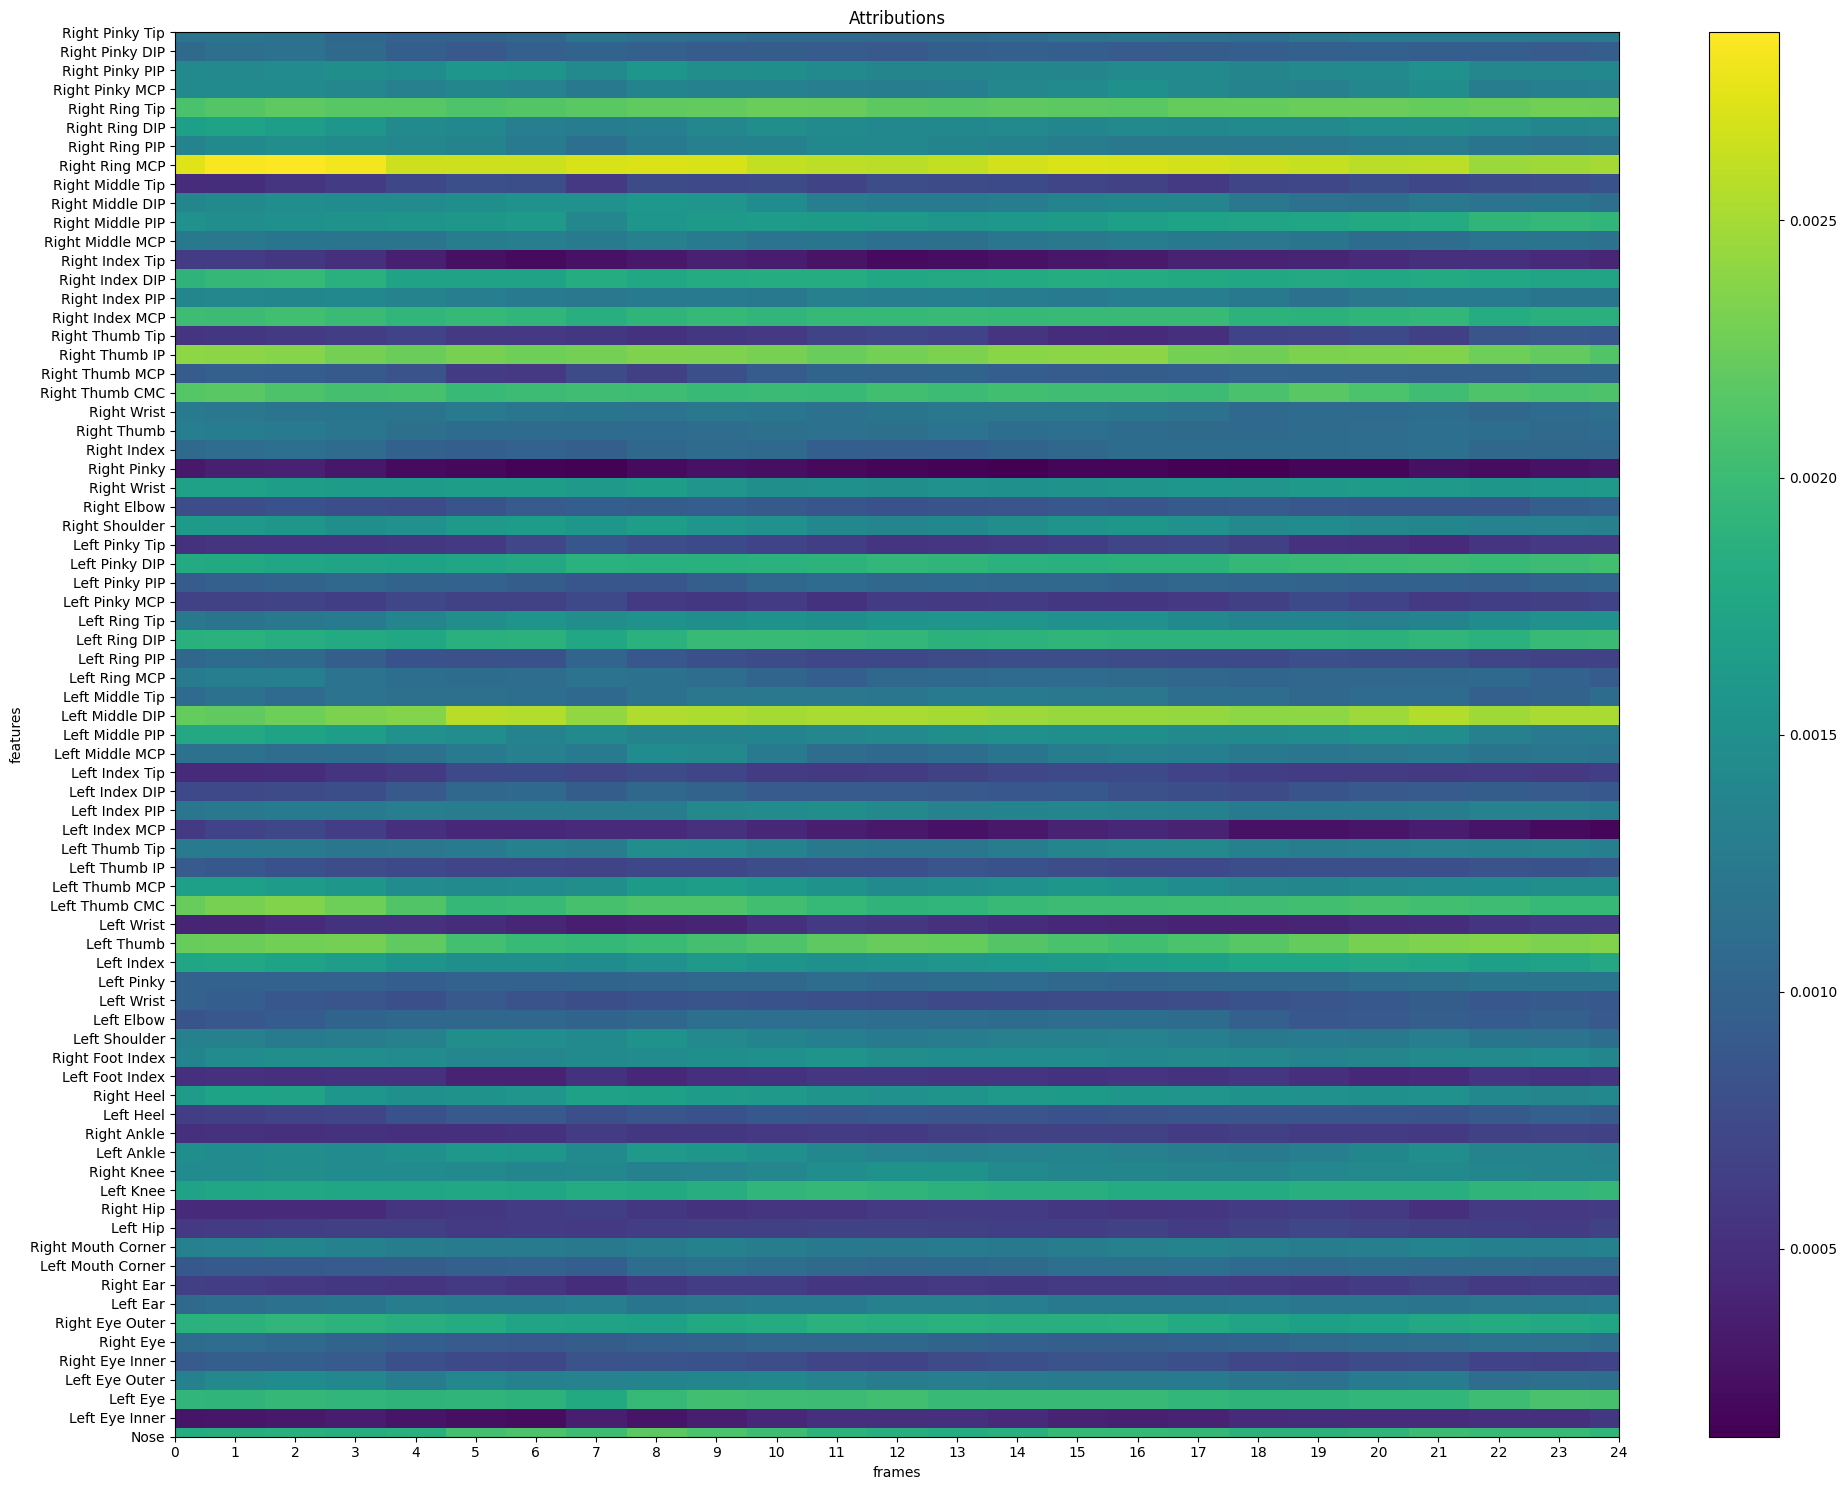

In [31]:
lm_attributions= analyse_layer.landmark_attributions(model= model,
                                                     captum_method= sailency,
                                                     video_detection= video_detection,
                                                     label= label,
                                                     device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_attributions, save_path= None, show_landmark_names= True)

  0%|          | 0/127 [00:00<?, ?it/s]

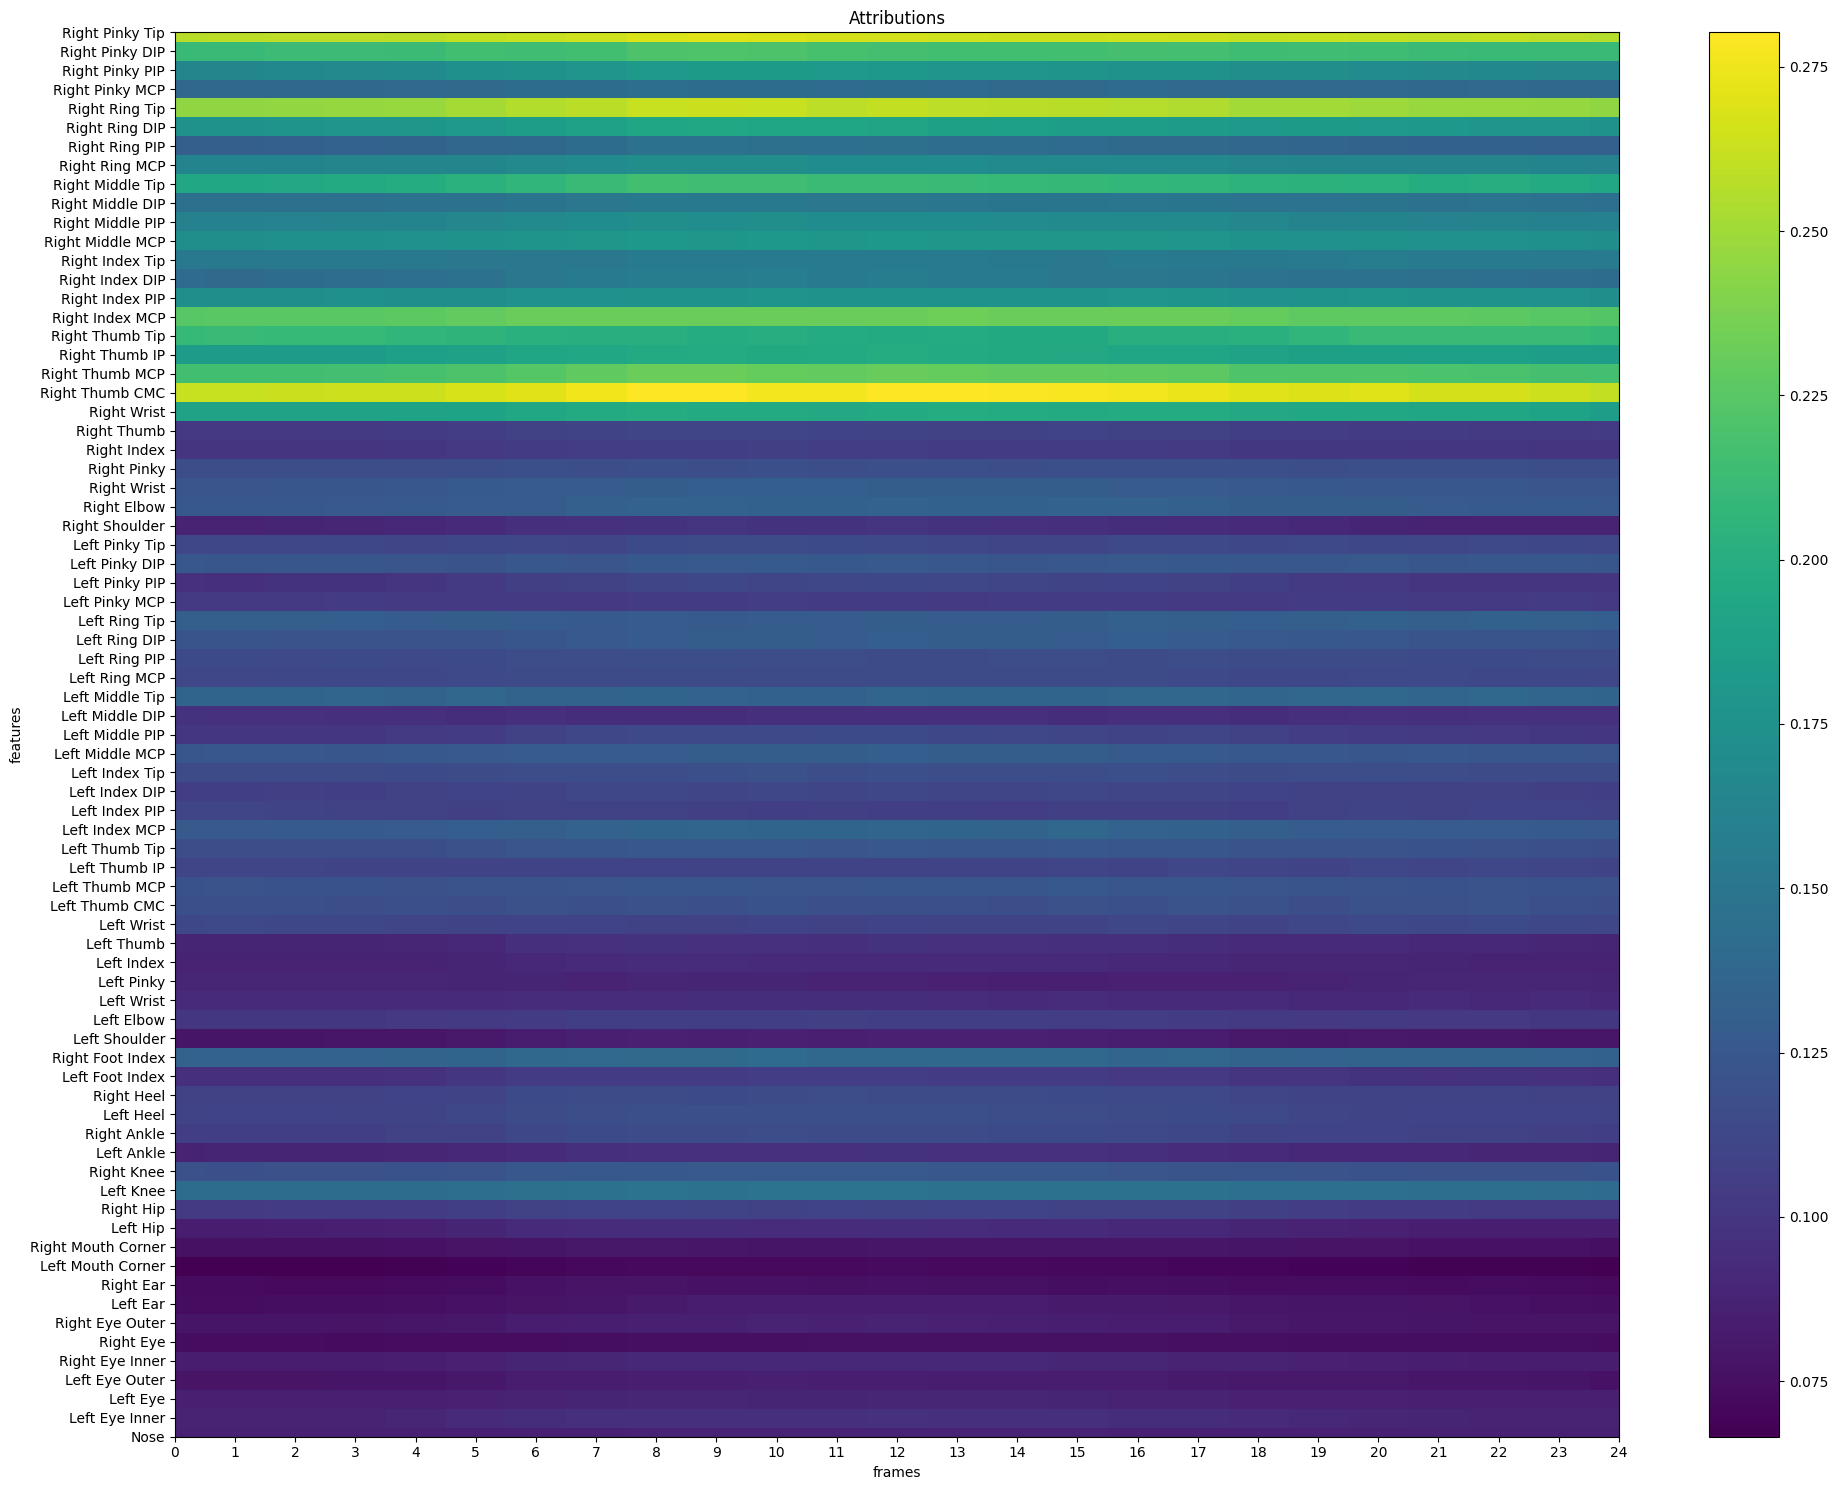

In [47]:
lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                 captum_method= sailency,
                                                                 dataset= test_dataset,
                                                                 device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset, save_path= None, show_landmark_names= True)

Training Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

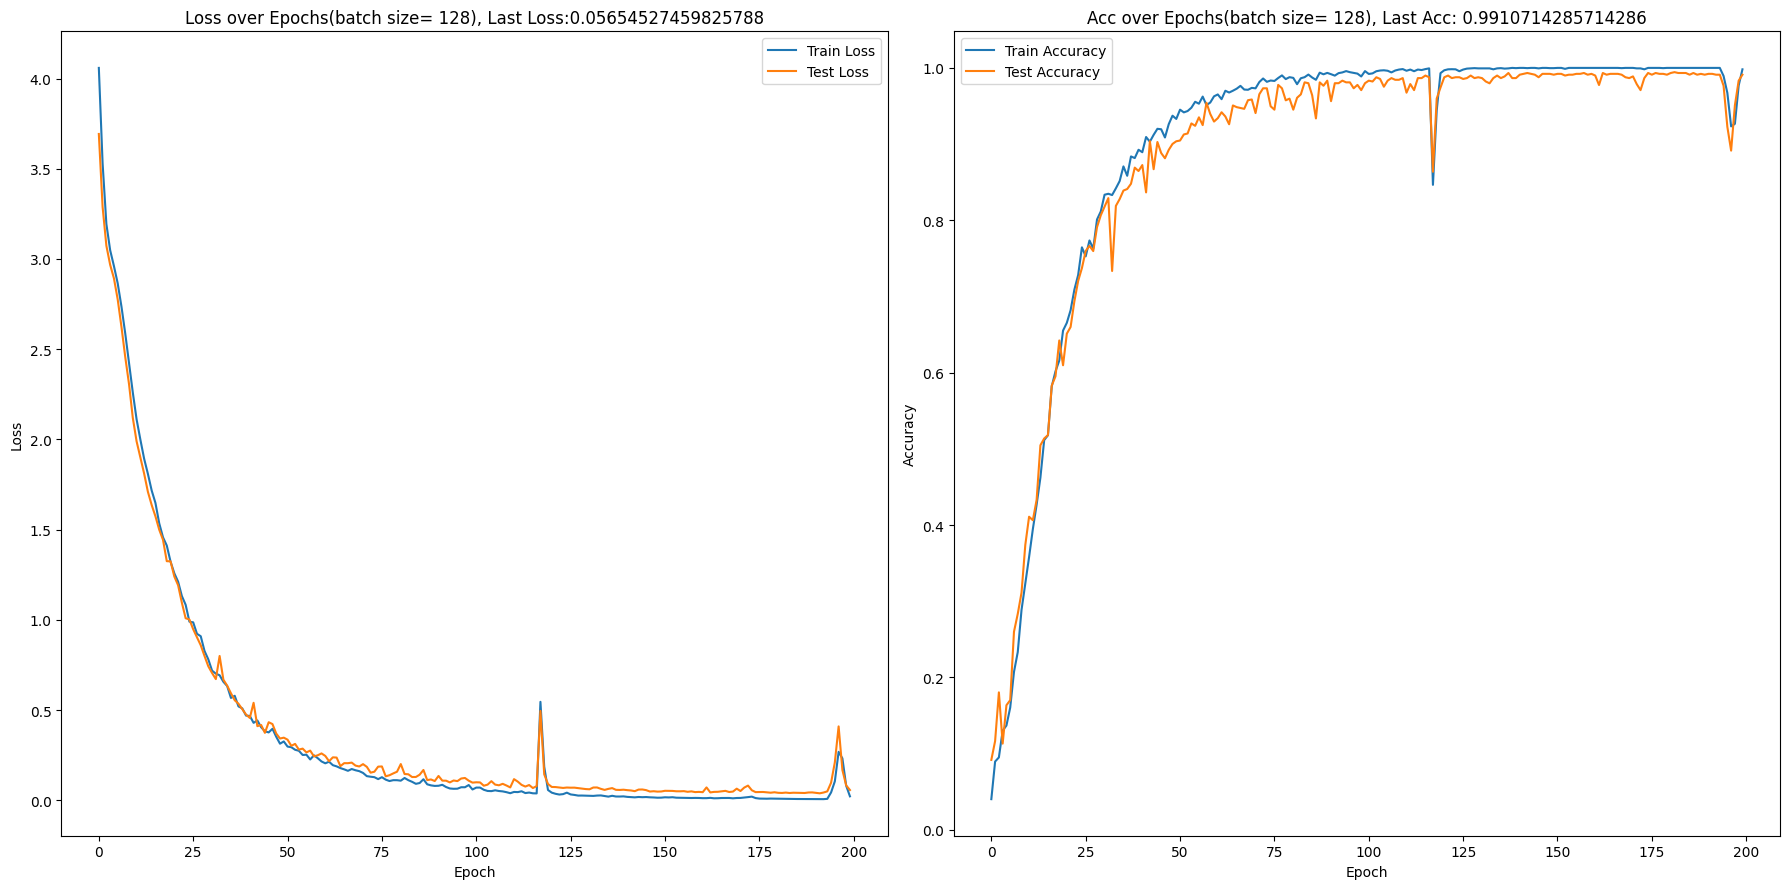

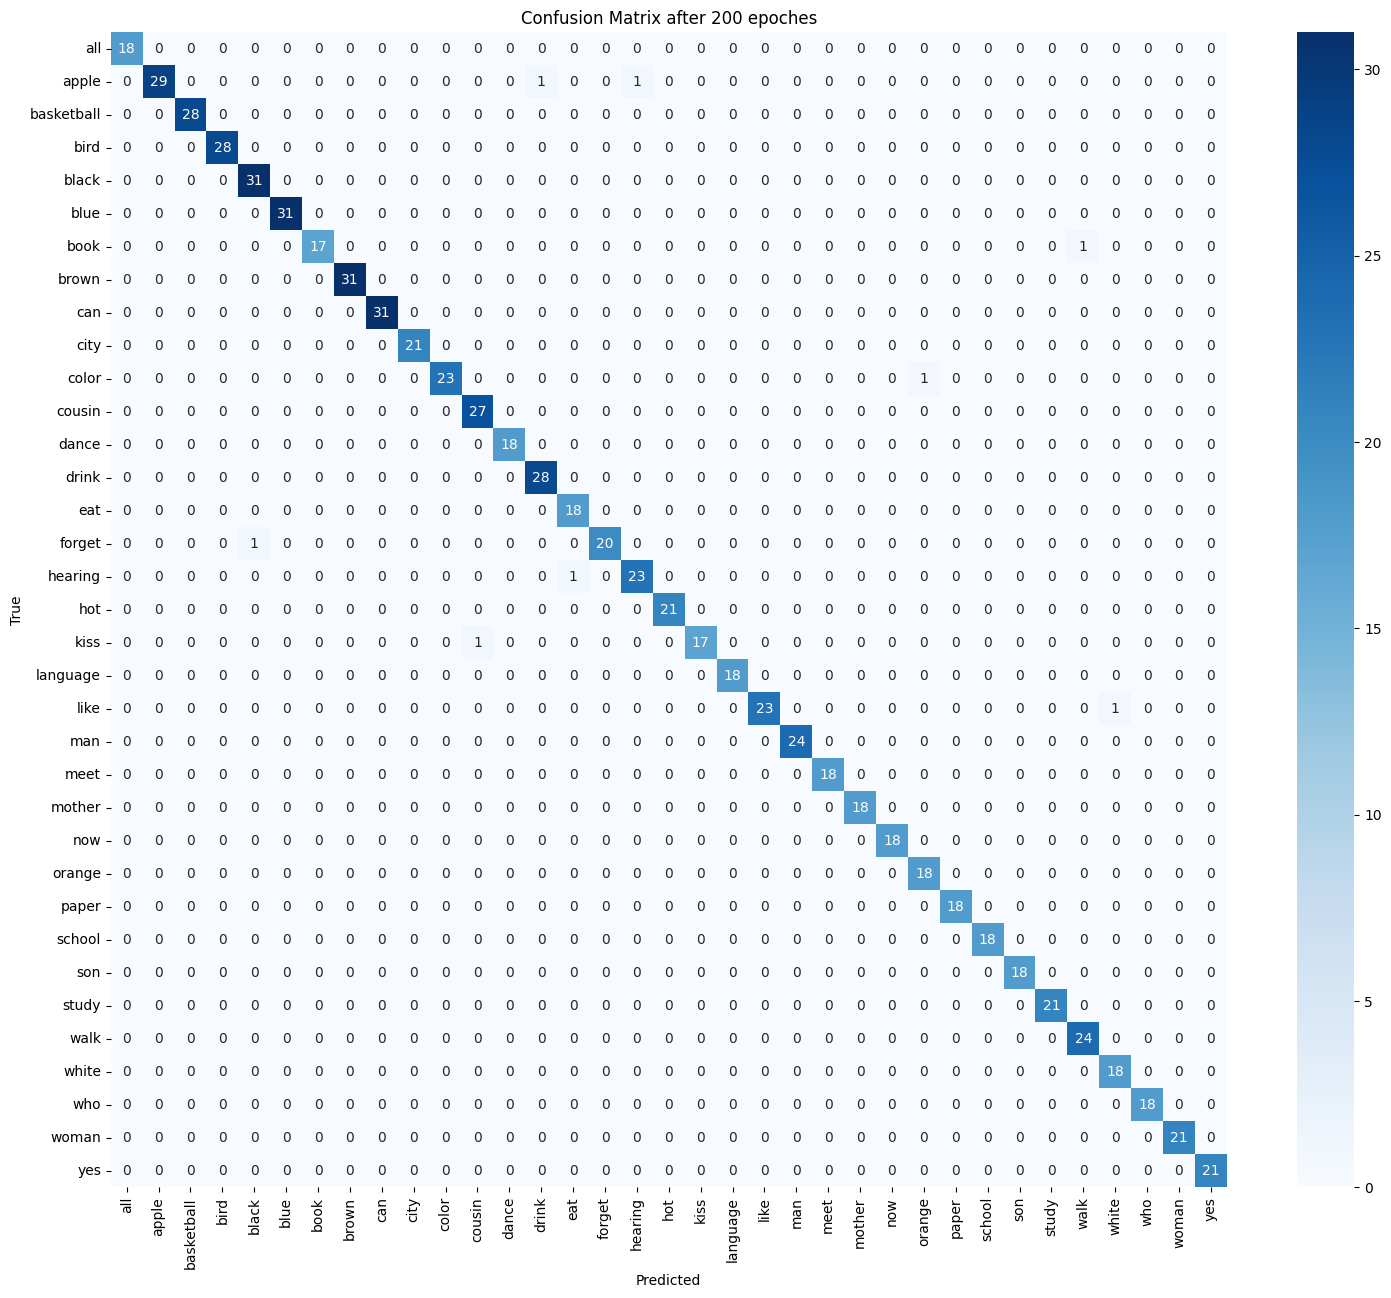

In [106]:
train.configure(detections= filtered_detections,
                labels= labels,
                class_names= prepare_datasets.wlasl35class_names, 
                test_size= 0.2, 
                batch_size= 128,
                num_epochs= 200,
                model= model,
                lr= 0.0001,
                device= device,
                quick_save= False,
                results_name= 'something',
                dataset_name= 'WLASL100')

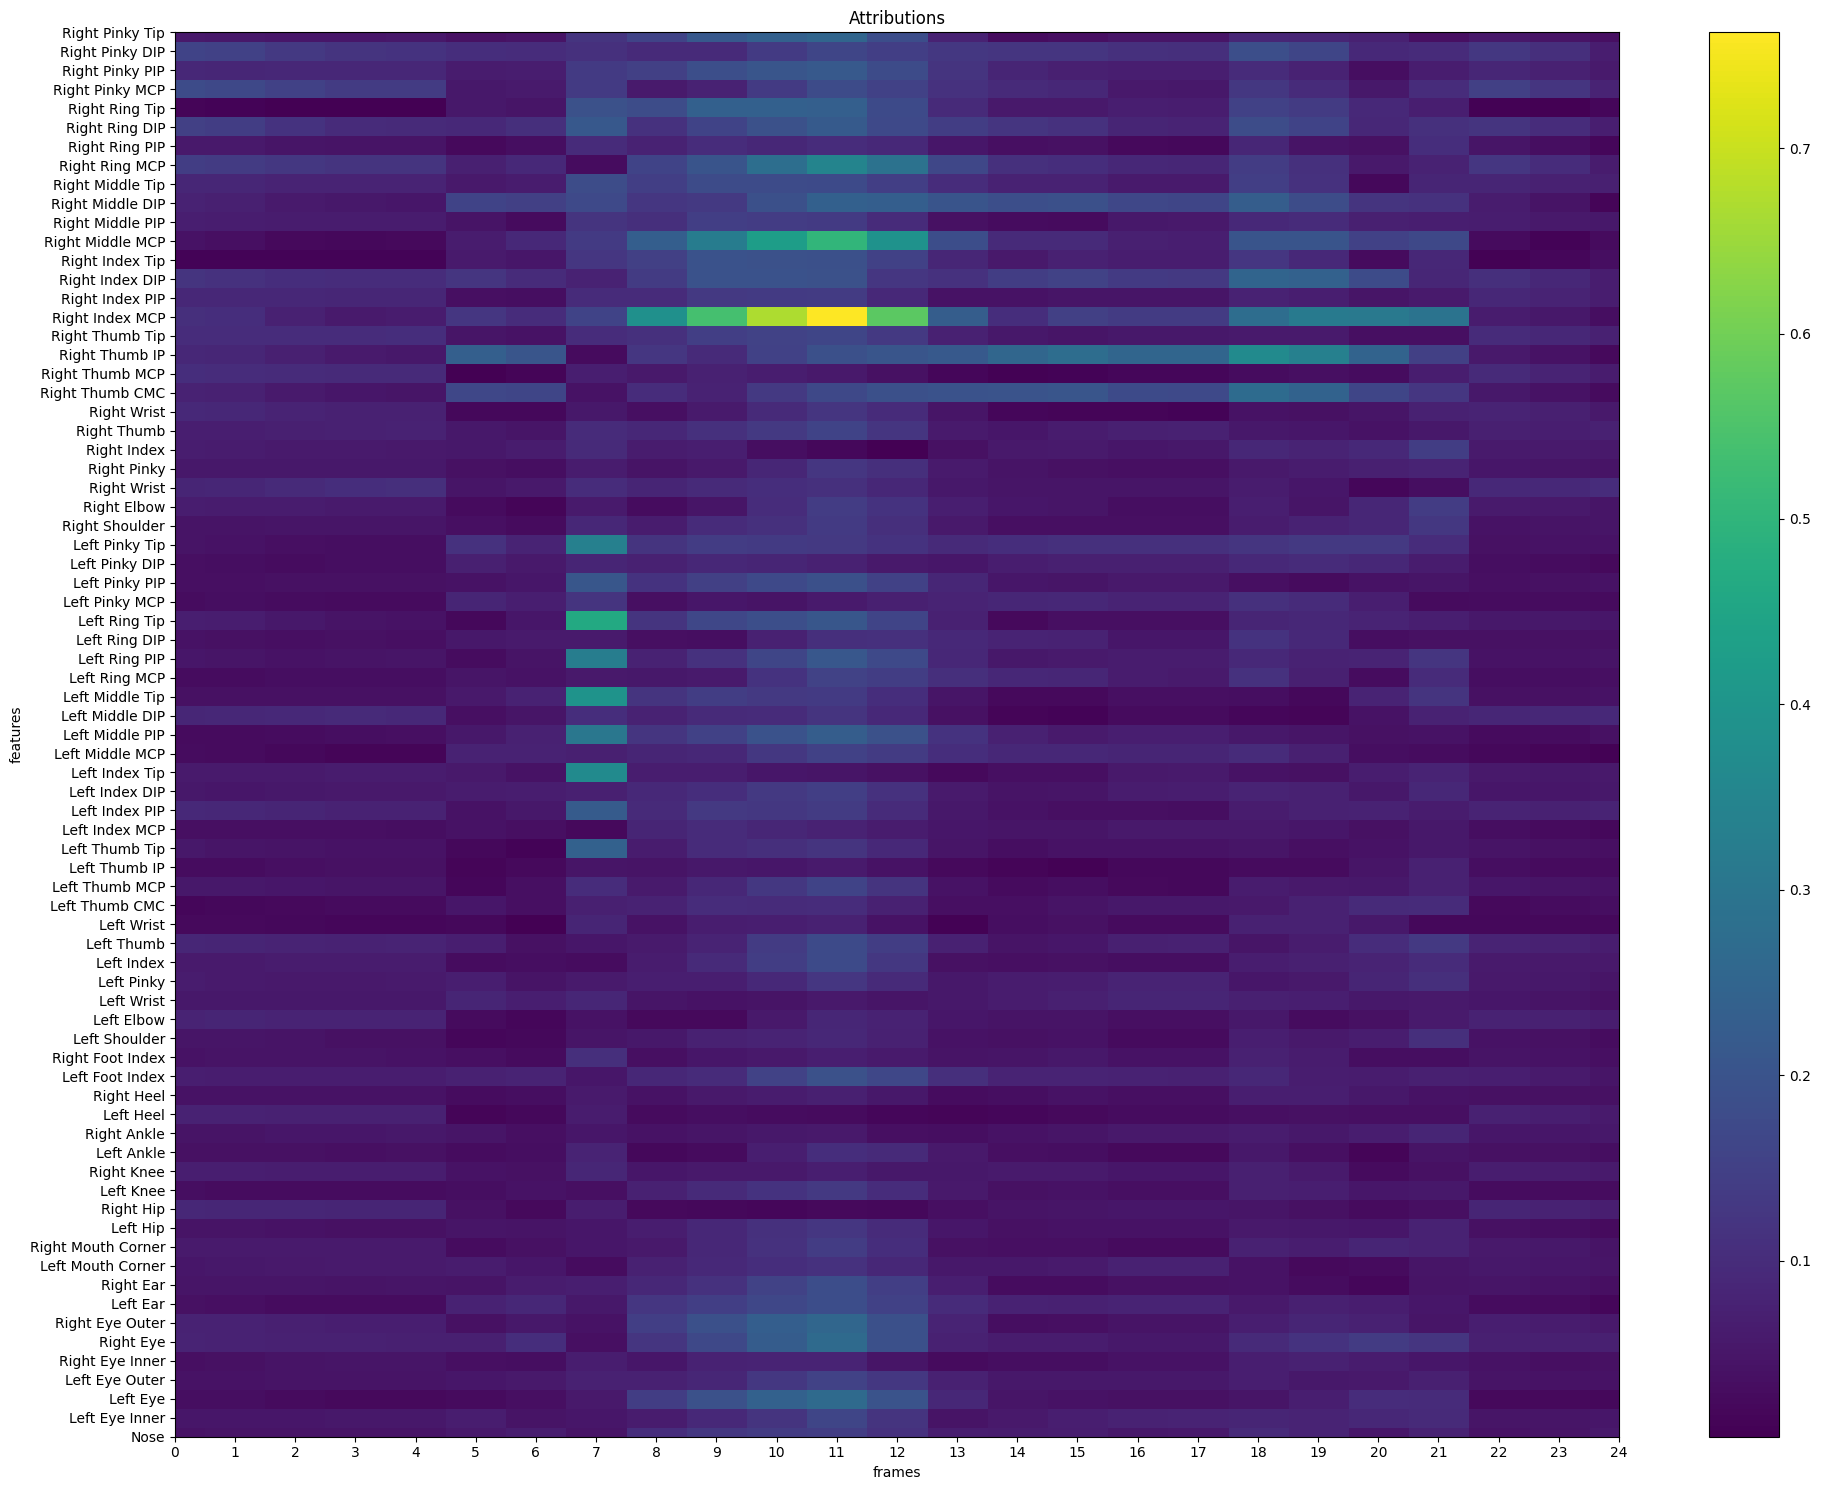

In [35]:
lm_attributions= analyse_layer.landmark_attributions(model= model,
                                                     captum_method= sailency,
                                                     video_detection= video_detection,
                                                     label= label,
                                                     device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_attributions, save_path= None, show_landmark_names= True)

  0%|          | 0/4000 [00:00<?, ?it/s]

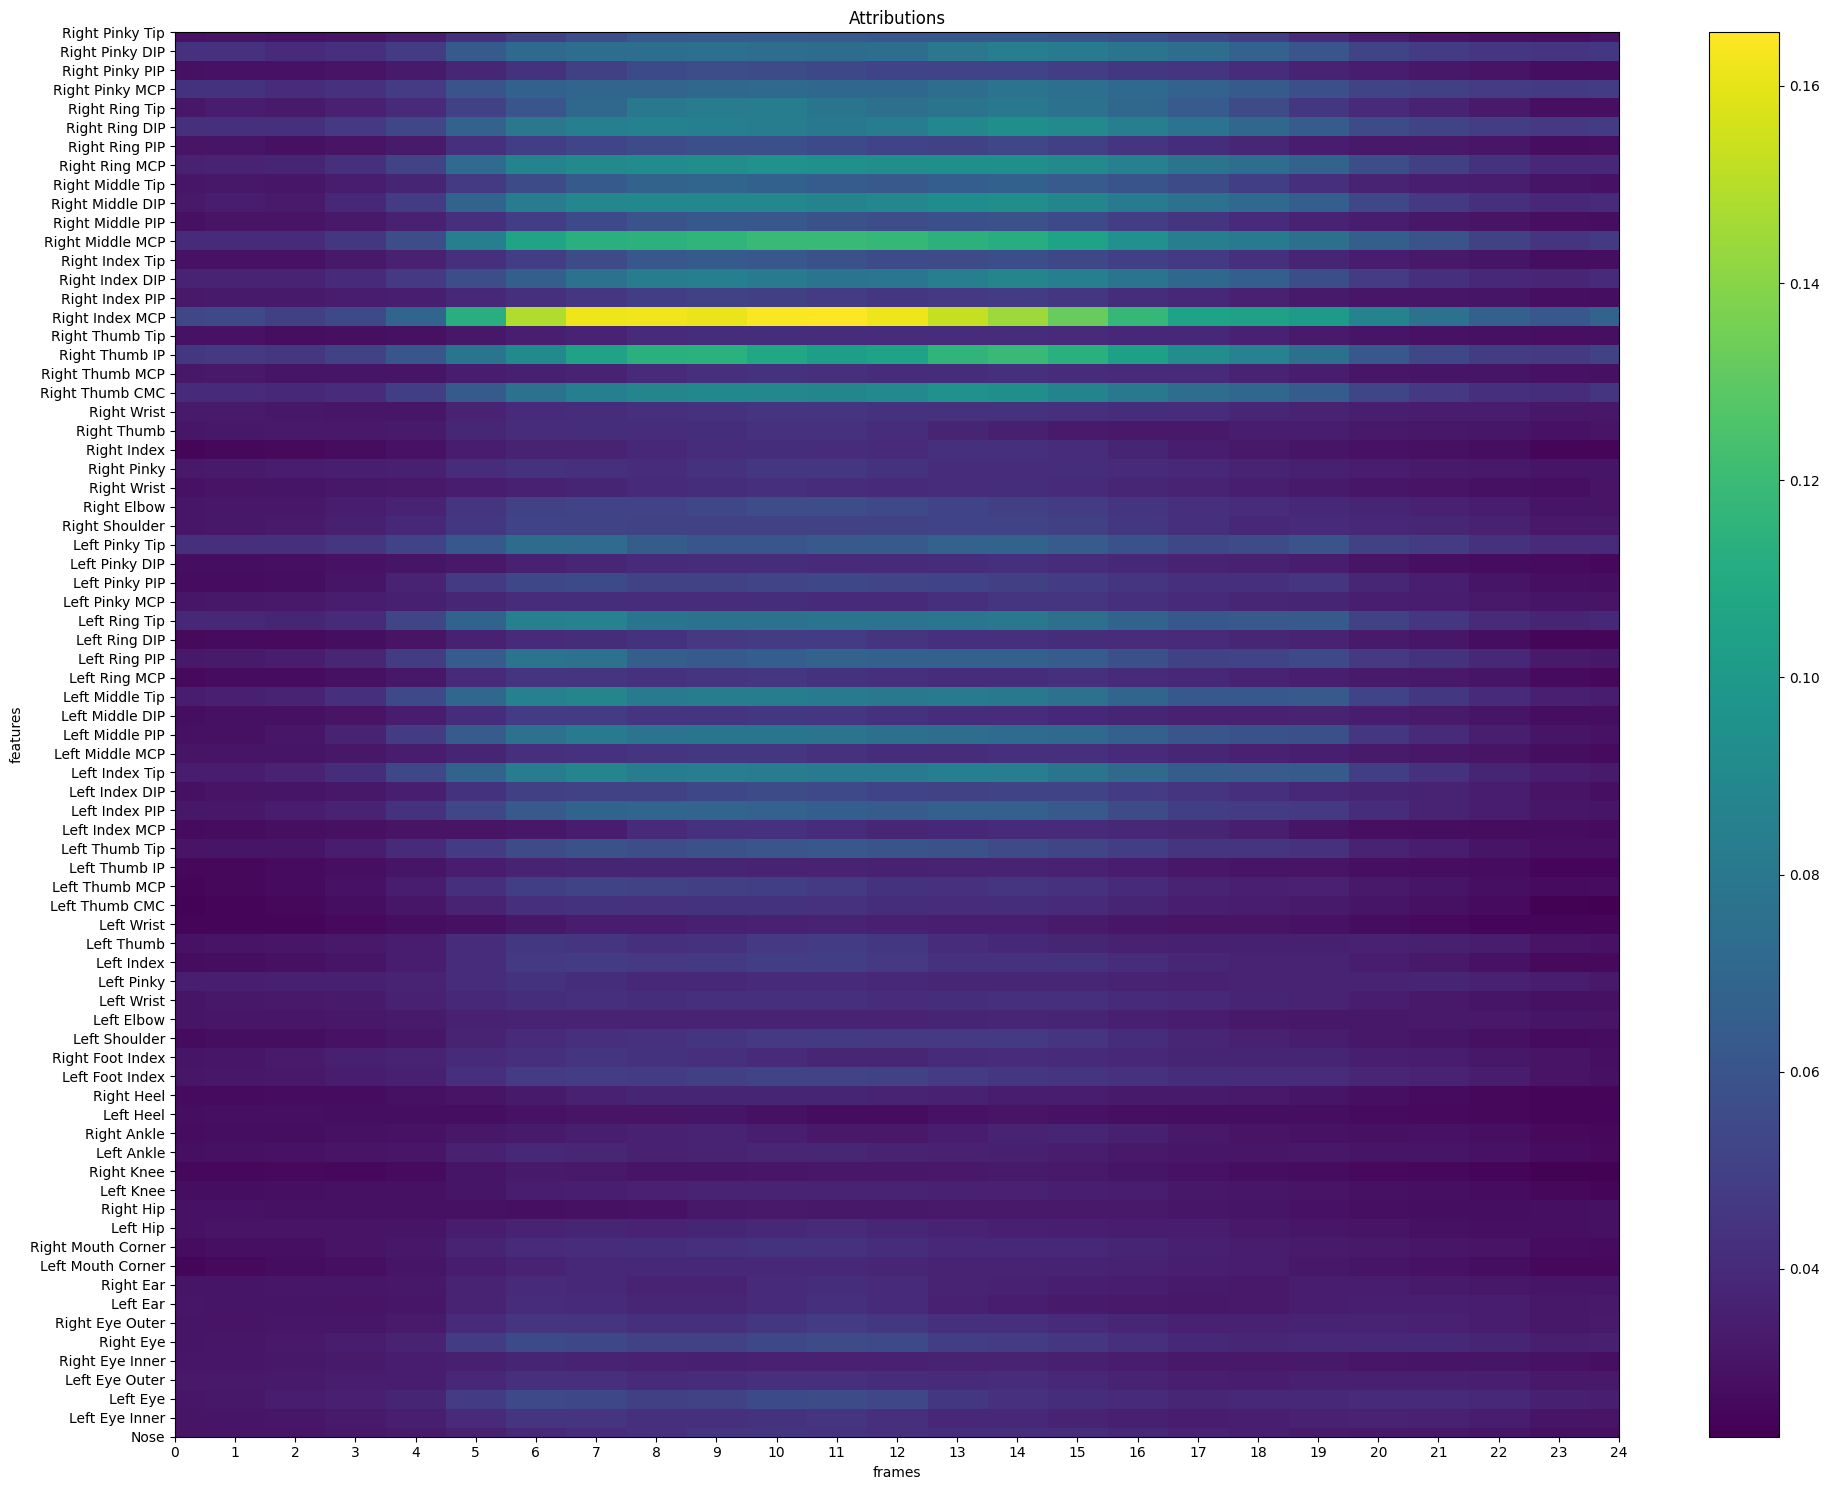

In [36]:
lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                 captum_method= sailency,
                                                                 dataset= dataset,
                                                                 device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset, save_path= None, show_landmark_names= True)

# Calculating attributions based on words.

In [ ]:
from torch.utils.data import Subset

word_positions = defaultdict(list)
for i, (data, label) in enumerate(dataset):
    word_positions[label.item()].append(i)

for i in range(len(prepare_datasets.lsa64class_names)):
    subset_dataset = Subset(dataset, word_positions[i])  # Correct the variable name (i not I)
    lm_atts_word = analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                   captum_method= sailency,
                                                                   dataset= subset_dataset,
                                                                   device= device)
    
    analyse_layer.plot_atts_heatmap(attributions= lm_atts_word, save_path= None, show_landmark_names= True)

# Testing cross validation functions:

In [16]:
model_args = {'class_names': prepare_datasets.wlasl100class_names,
              'seq_len': 25,
              'd_model': 258,              
              'nhead': 6, 
              'd_ff': 512,                
              'num_layers': 2, 
              'dropout': 0.1}

------------------------------------------------------------------------------------------------------------------------------
Fold 1


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

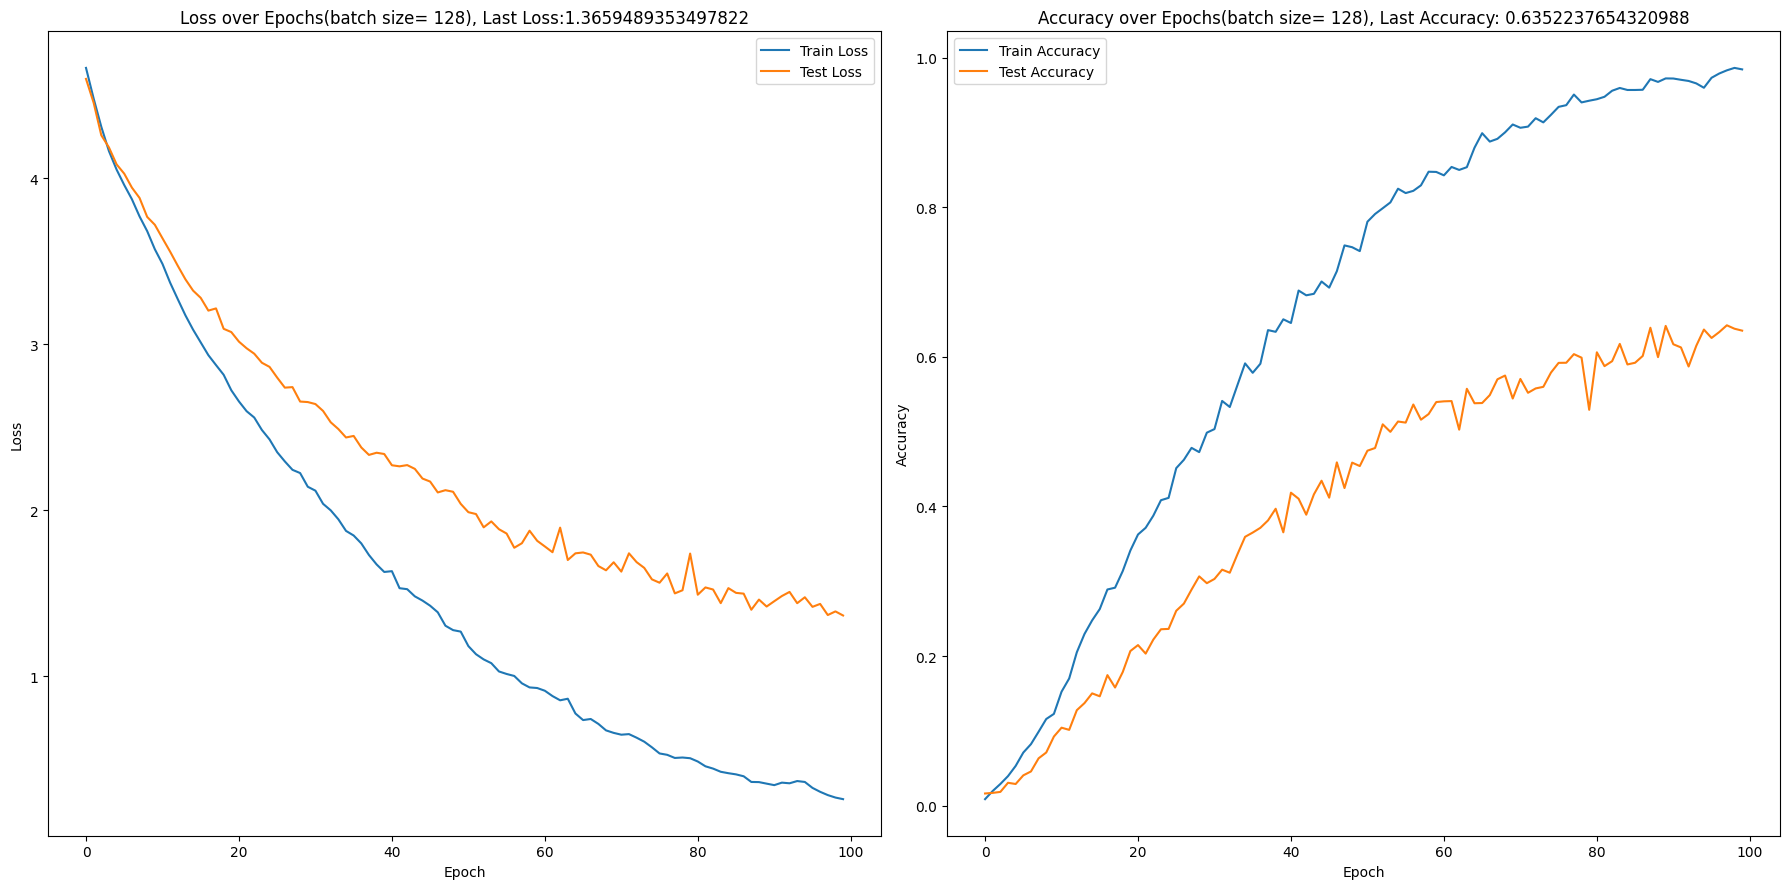

------------------------------------------------------------------------------------------------------------------------------
Fold 2


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

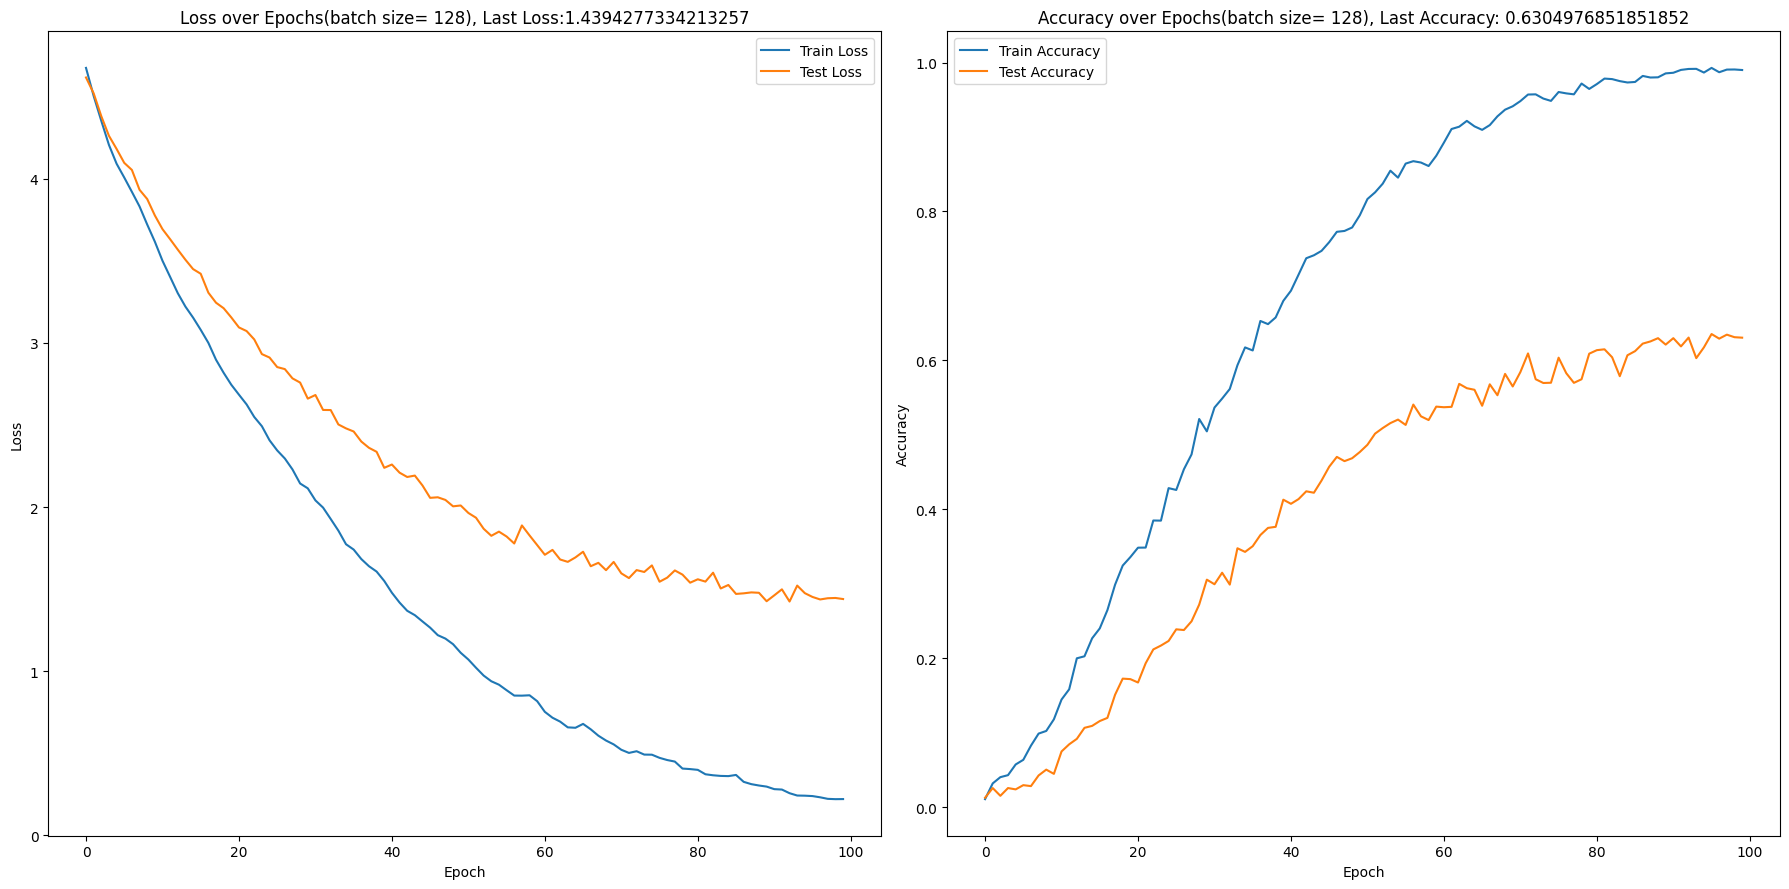

------------------------------------------------------------------------------------------------------------------------------
Fold 3


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

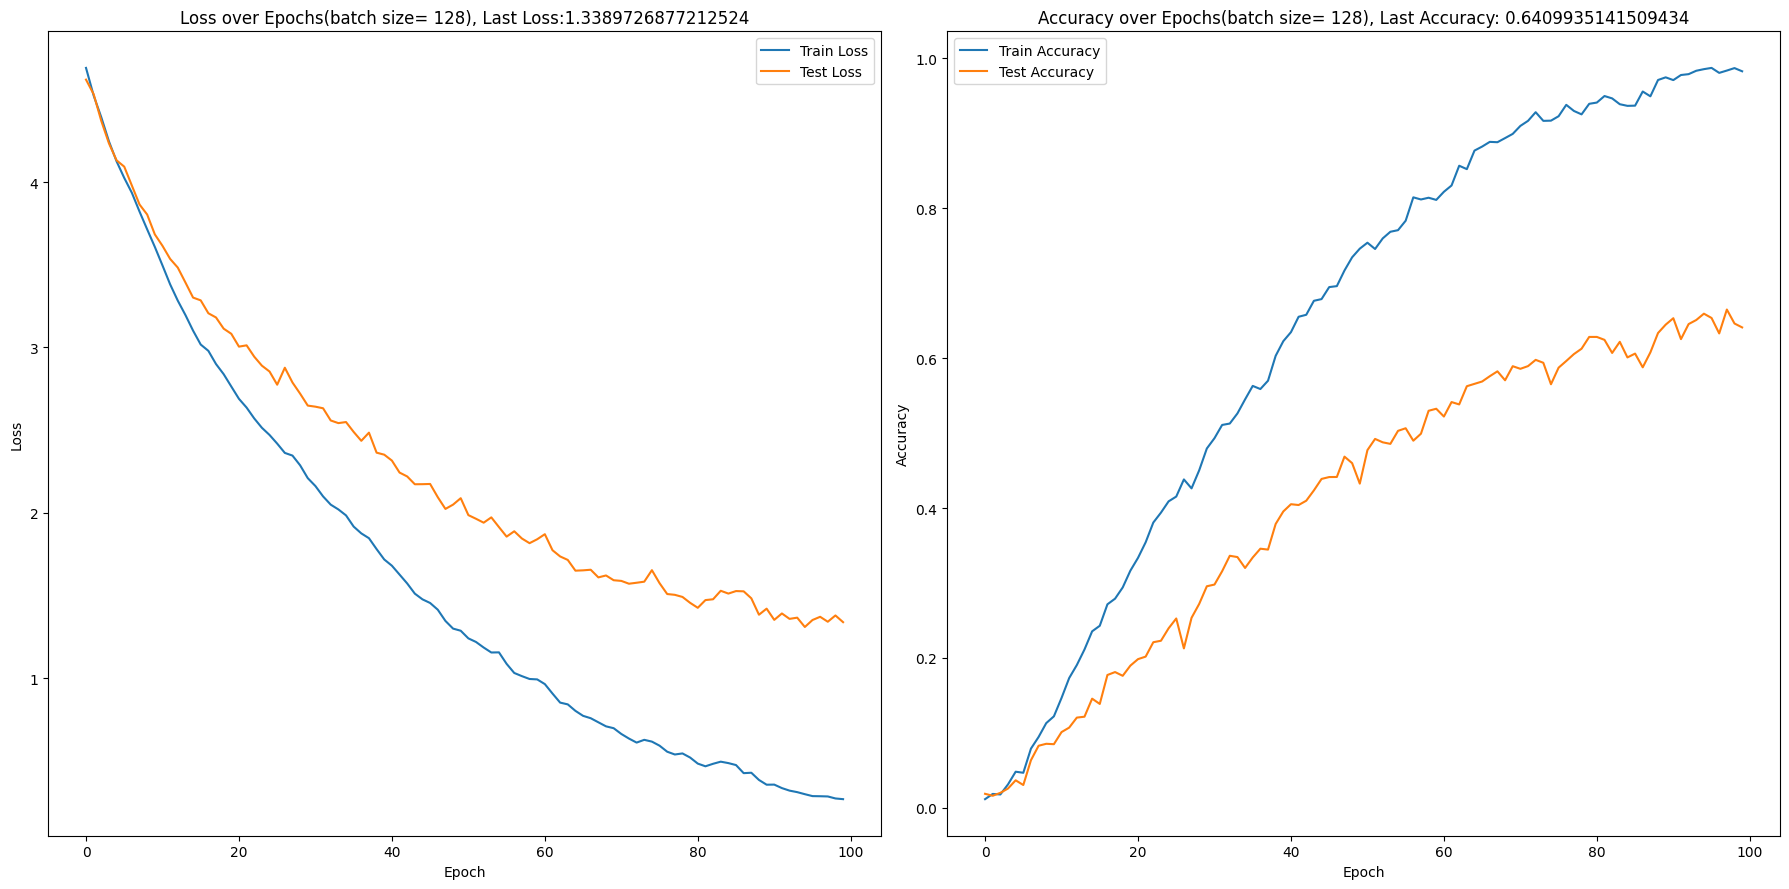

In [17]:
train.configure_Kfold(detections= filtered_detections,
                      labels= wlasl100_labels,
                      class_names= prepare_datasets.wlasl100class_names,
                      n_splits= 5,
                      batch_size= 128,
                      num_epochs= 100,
                      model_class= models.Transformer,
                      model_args= model_args,
                      lr= 0.0001,
                      device= device,
                      quick_save= False)